In [2]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

In [5]:
load_dotenv()

server = os.getenv("SERVER_NAME")
database = os.getenv("SERVER_DATABASE")
driver = os.getenv("SERVER_DRIVER")

connection_str = f'mssql+pyodbc://@{server}/{database}?driver={driver}&trusted_connection=yes'

engine =create_engine(connection_str)

query = """
SELECT 
    -- Target
    o.otd_flag,
    
    -- Features
    o.approval_time_days,
    o.dest_state,
    o.zip_code as dest_zip,
    
    i.precio,
    i.flete,
    i.categoria_nombre_ingles,
    i.vendedor_estado,
    i.vendedor_zip_code,
    
    -- Feature Engineering (Calculate if it is interstate)
    CASE WHEN o.dest_state = i.vendedor_estado THEN 1 ELSE 0 END as same_region
    
FROM dbo.FACT_Ordenes o
JOIN dbo.FACT_Items i ON o.ORDEN_ID = i.order_id
WHERE o.otd_flag IS NOT NULL
"""

In [8]:
df = pd.read_sql_query(query, engine)

print("Header of data loaded:")
print(df.head())

Header of data loaded:
   otd_flag  approval_time_days dest_state  dest_zip  precio  flete  \
0       1.0                 1.0         SP   11075.0   145.0   11.0   
1       1.0                 0.0         SP    6636.0    53.0   11.0   
2       1.0                 0.0         RJ   27213.0   119.0   44.0   
3       1.0                 0.0         RJ   22461.0    48.0   16.0   
4       1.0                 1.0         RJ   26263.0   219.0   16.0   

  categoria_nombre_ingles vendedor_estado  vendedor_zip_code  same_region  
0           health_beauty              SP               3702            1  
1         books_technical              SP               2274            1  
2        office_furniture              SP               8577            0  
3              cool_stuff              SP               9350            0  
4          sports_leisure              PR              83605            0  


In [ ]:
from sklearn.preprocessing import LabelEncoder

#The Fact table is alrady cleaned, just do it for safety
df = df.dropna()

df["proxy_distance"] = abs(df['dest_zip'] - df['vendedor_zip_code'])

encoder = LabelEncoder() #Could use OHE or Target encoder (from category_encoders import TargetEncoder)

# encode category names
df['category_encoded'] = encoder.fit_transform(df['categoria_nombre_ingles'])

# encode ALL states
stateEncoder = LabelEncoder()
all_states = pd.concat([df['dest_state'], df['vendedor_estado']])
stateEncoder.fit(all_states)

df['dest_state_enc'] = stateEncoder.transform(df['dest_state'])
df['vend_state_enc'] = stateEncoder.transform(df['vendedor_estado'])

In [ ]:
features = [
    'approval_time_days', 
    'precio', 
    'flete', 
    'same_region', 
    'proxy_distance', 
    'category_encoded', 
    'dest_state_enc', # destination state (costumer)
    'vend_state_enc' # seller state
]

In [23]:
X = df[features]
y = df['otd_flag'] # 1 = On time, 0 = Late (based in our DB Fact table)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.67      0.14      0.23      1435
         1.0       0.94      1.00      0.97     20182

    accuracy                           0.94     21617
   macro avg       0.81      0.57      0.60     21617
weighted avg       0.92      0.94      0.92     21617



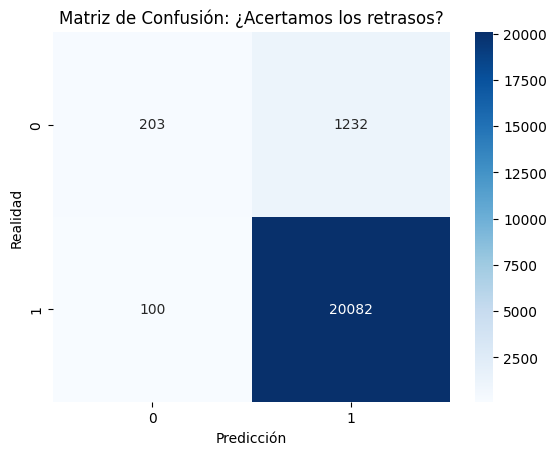

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Forecast")
plt.ylabel("Reality")
plt.show()

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.71      0.14      0.24      1435
         1.0       0.94      1.00      0.97     20182

    accuracy                           0.94     21617
   macro avg       0.83      0.57      0.60     21617
weighted avg       0.93      0.94      0.92     21617



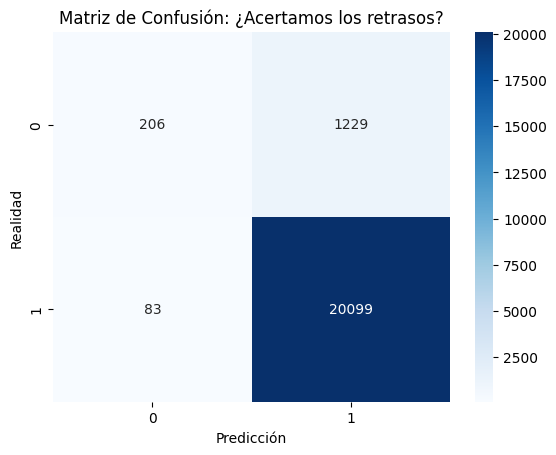

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report with Balanced Classes:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Forecast")
plt.ylabel("Reality")
plt.show()

Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Mejores Hiperparámetros encontrados:
{'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}

Mejor F1-Score (Macro) obtenido: 0.59

--- Reporte del Modelo Optimizado ---
              precision    recall  f1-score   support

         0.0       0.37      0.19      0.25      1435
         1.0       0.94      0.98      0.96     20182

    accuracy                           0.93     21617
   macro avg       0.66      0.58      0.60     21617
weighted avg       0.91      0.93      0.91     21617



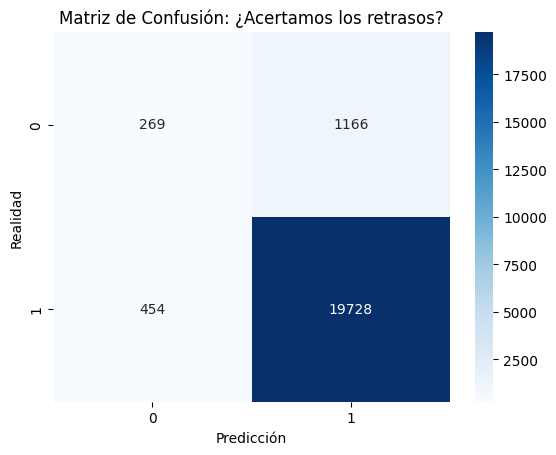

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'class_weight': ['balanced', 'balanced_subsample', None], 
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4] 
}

rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,                 # Cross Validation of 3 folds
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("Starting hyperparameter search CV...")
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

print(f"\nBest F1-Score (Macro) obtained: {grid_search.best_score_:.2f}")

best_rf = grid_search.best_estimator_
y_pred_opt = best_rf.predict(X_test)

print("\n--- Optimized Model Report ---")
print(classification_report(y_test, y_pred_opt))

cm = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Forecast")
plt.ylabel("Reality")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20944\161814356.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


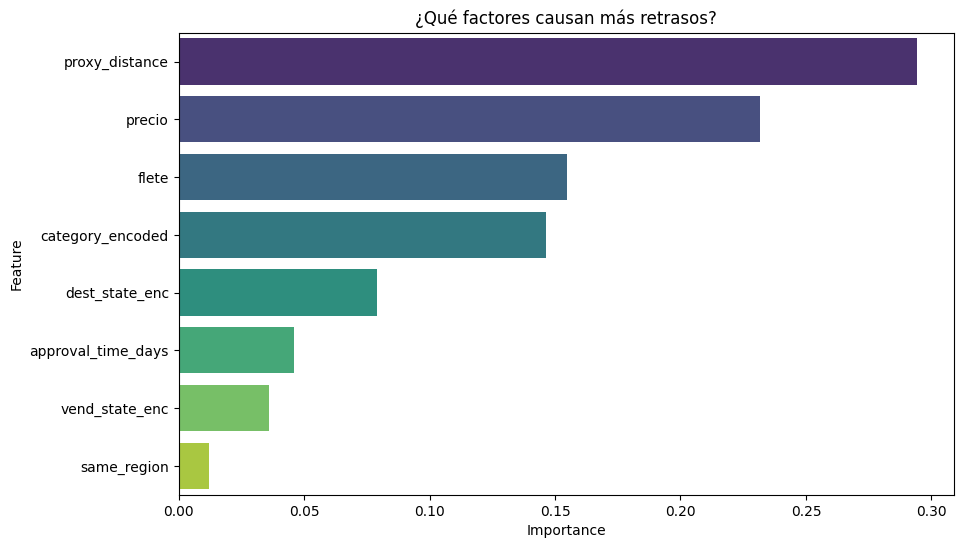

In [ ]:
# Extract feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False)

# Plot RF feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title("What factors cause the most delays?")
plt.show()


--- Reporte del Modelo Optimizado ---
              precision    recall  f1-score   support

         0.0       0.12      0.64      0.20      1435
         1.0       0.96      0.67      0.79     20182

    accuracy                           0.67     21617
   macro avg       0.54      0.65      0.50     21617
weighted avg       0.91      0.67      0.75     21617



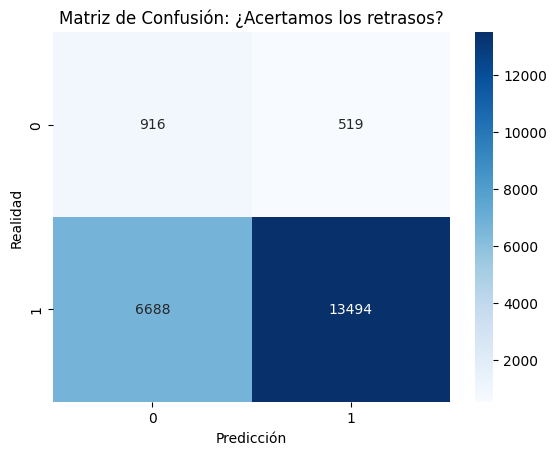

In [ ]:
import numpy as np

probs = best_rf.predict_proba(X_test)

# Nos quedamos con la probabilidad de la clase 0 (Retraso)
probs_retraso = probs[:, 0]

# Bajamos la vara: Si hay más de 30% de probabilidad de retraso, márcalo como retraso
y_pred_ajustado = (probs_retraso > 0.3).astype(int) 

y_pred_ajustado = np.where(probs_retraso > 0.20, 0, 1)

print("\n--- Optimized Model Report ---")
print(classification_report(y_test, y_pred_ajustado))

cm = confusion_matrix(y_test, y_pred_ajustado, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Forecast")
plt.ylabel("Reality")
plt.show()